In [2]:
#importing Libraries

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

In [3]:
#Load the dataset

_URL = 'https://datasetdownloadslinks.s3.us-east-1.amazonaws.com/Download%20Datasets/Animal%20Faces.zip'
path_to_zip = tf.keras.utils.get_file('Animal Faces.zip', origin=_URL, extract=True)

# The dataset is extracted to a folder called 'afhq'
PATH = os.path.join(os.path.dirname(path_to_zip), 'afhq')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

729700755/729700755 ━━━━━━━━━━━━━━━━━━━━ 60s 0us/step
Found 14630 files belonging to 3 classes.


In [4]:
#Training and Preprocessing

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [5]:
val_datagen = ImageDataGenerator(rescale=1.0/255)

In [6]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [7]:
# Load a pretrained model (ResNet50) without the top layer

Base_Model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
# Freeze all layers in the base model

for layer in Base_Model.layers:
    layer.trainable = False

In [9]:
# Add new layers for fine-tuning

X = Base_Model.output
X = GlobalAveragePooling2D()(X)
X = Dense(1024, activation='relu')(X)
predictions = Dense(train_generator.num_classes, activation='softmax')(X)

In [10]:
# final model

Final_Model = Model(inputs=Base_Model.input, outputs=predictions)

In [11]:
# Compile the model

Final_Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Callback for visualizing
Callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="./logs")
]


In [13]:
# Train the model
History = Final_Model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=Callbacks
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


457/457 ━━━━━━━━━━━━━━━━━━━━ 259s 527ms/step - accuracy: 0.4456 - loss: 1.1076 - val_accuracy: 0.5543 - val_loss: 0.9100
Epoch 2/10
  1/457 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.5312 - loss: 0.9359

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5312 - loss: 0.9359 - val_accuracy: 0.6786 - val_loss: 0.8678
Epoch 3/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 232s 489ms/step - accuracy: 0.5761 - loss: 0.8943 - val_accuracy: 0.7398 - val_loss: 0.6858
Epoch 4/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - accuracy: 0.6875 - loss: 0.7833 - val_accuracy: 0.7500 - val_loss: 0.7318
Epoch 5/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 240s 519ms/step - accuracy: 0.5959 - loss: 0.8570 - val_accuracy: 0.6291 - val_loss: 0.7575
Epoch 6/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - accuracy: 0.6562 - loss: 0.7328 - val_accuracy: 0.5714 - val_loss: 0.8914
Epoch 7/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 227s 491ms/step - accuracy: 0.6148 - loss: 0.8277 - val_accuracy: 0.6977 - val_loss: 0.6865
Epoch 8/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - accuracy: 0.5312 - loss: 0.8535 - val_accuracy: 0.6786 - val_loss: 0.5803
Epoch 9/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 228s 493ms/step - accuracy: 0.6384 - loss: 0.7862 - val_

In [16]:
# Unfreeze the deeper layers for further fine-tuning

for layer in Base_Model.layers[-20:]:
    layer.trainable = True

In [19]:
# Recompile the model with a lower learning rate for fine-tuning
# Assuming Final_Model was the original model instance that needs recompiling:

Final_Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Fine-tune the model using Final_Model instead of Base_Model
history_fine = Final_Model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5,
    callbacks=Callbacks
)

Epoch 1/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 270s 547ms/step - accuracy: 0.6670 - loss: 1.3358 - val_accuracy: 0.7160 - val_loss: 0.6492
Epoch 2/5
  1/457 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - accuracy: 0.8438 - loss: 0.3775

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


457/457 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8438 - loss: 0.3775 - val_accuracy: 0.7500 - val_loss: 0.5722
Epoch 3/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 286s 492ms/step - accuracy: 0.7789 - loss: 0.5474 - val_accuracy: 0.8064 - val_loss: 0.4986
Epoch 4/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - accuracy: 0.8438 - loss: 0.4919 - val_accuracy: 0.8571 - val_loss: 0.3603
Epoch 5/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 257s 484ms/step - accuracy: 0.8031 - loss: 0.4761 - val_accuracy: 0.8186 - val_loss: 0.4683


In [25]:
# Evaluate the model

val_generator.reset()
# Assuming 'Final_Model' is your trained model:
Preds = Final_Model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size + 1)
Y_Pred = np.argmax(Preds, axis=1)  # Use 'Preds' here, not 'preds'
Y_True = val_generator.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step


In [28]:
# Generate classification report

Class_Labels = list(val_generator.class_indices.keys())
print(classification_report(Y_True, Y_Pred, target_names=Class_Labels))

              precision    recall  f1-score   support

         cat       0.36      0.32      0.34       500
         dog       0.33      0.45      0.38       500
        wild       0.30      0.23      0.26       500

    accuracy                           0.33      1500
   macro avg       0.33      0.33      0.32      1500
weighted avg       0.33      0.33      0.32      1500



In [29]:
# Generate confusion matrix

Conf_Matrix = confusion_matrix(Y_True, Y_Pred)
print("Confusion Matrix:")
print(Conf_Matrix)

Confusion Matrix:
[[158 213 129]
 [143 224 133]
 [137 249 114]]


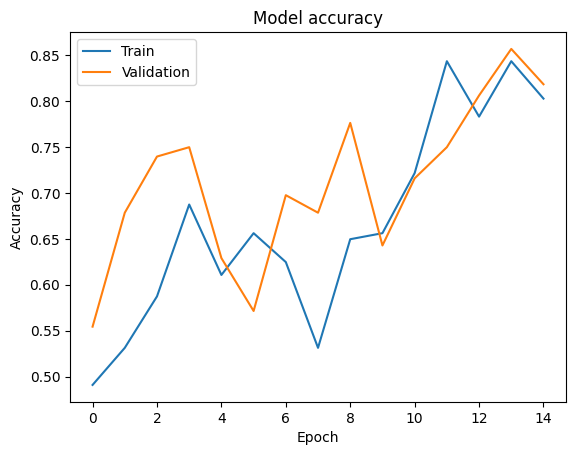

In [32]:
# Plot training & validation accuracy values

plt.plot(History.history['accuracy'] + history_fine.history['accuracy']) # Changed History_Fine to history_fine
plt.plot(History.history['val_accuracy'] + history_fine.history['val_accuracy']) # Changed History_Fine to history_fine
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

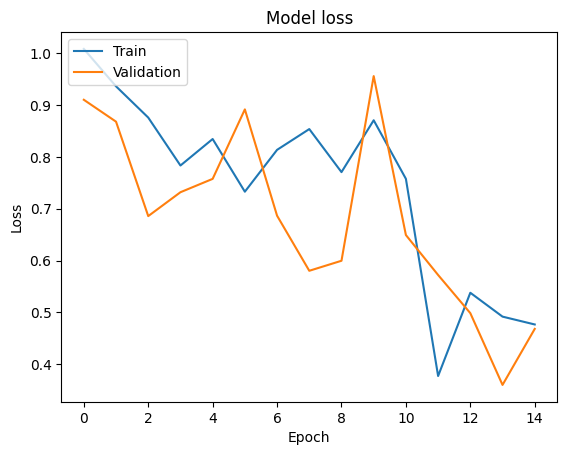

In [35]:
# Plot training & validation loss values

plt.plot(History.history['loss'] + history_fine.history['loss']) # Changed History_Fine to history_fine
plt.plot(History.history['val_loss'] + history_fine.history['val_loss']) # Changed History_Fine to history_fine
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()